### Seq2Seq Recurrent Translation


In [2]:
import os
import time
import re
import unicodedata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
# Global parameters

root_folder='.'
data_folder_name='data'
train_filename='ita.txt'

DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))
train_filenamepath = os.path.abspath(os.path.join(DATA_PATH, train_filename))

train_path = DATA_PATH
test_path = DATA_PATH

In [4]:
# Model parameters
INPUT_COLUMN = 'input'
TARGET_COLUMN = 'target'
TARGET_FOR_INPUT = 'target_for_input'
NUM_SAMPLES = 100000
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 128
HIDDEN_DIM = 1024 # Number of cells in the hidden recurrent layers

BATCH_SIZE = 64
EPOCHS = 25

In [5]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    w = re.sub(r"([?.!,])", r" \1 ", w) 

    # Replacement of unwanted characters with a space
    w = re.sub(r"[^a-zA-Z?.!,]+", " ", w)

    w = re.sub(r'[" "]+', " ", w) # Removal of consecutive spaces
    return w

### Loading the dataset
Loading the dataset into a Pandas DataFrame and applying preprocessing functions on it in the Input and Target columns.

In [6]:
# Loading the dataset: sentence in English, sentence in Italian
df = pd.read_csv(
    train_filenamepath,
    sep="\t",
    header=None,
    names=[INPUT_COLUMN, TARGET_COLUMN],
    usecols=[0,1],
    nrows=NUM_SAMPLES
)

print(df.iloc[42:52], '\n')

# Preprocessing of Input data
input_data = df[INPUT_COLUMN].apply(lambda x : preprocess_sentence(x)).tolist()

# Preprocessing of Target data with the addition of the end-of-sentence token
target_data_eos = df[TARGET_COLUMN].apply(lambda x : preprocess_sentence(x)+ ' <eos>').tolist()

# Preprocessing of Target data with the addition of the start-of-sentence token
target_data_sos = df[TARGET_COLUMN].apply(lambda x : '<sos> '+ preprocess_sentence(x)).tolist()

print(input_data[:5])
print(target_data_eos[:5])
print(target_data_sos[:5])

     input          target
42  Do it.      Lo faccia.
43  Do it.      La faccia.
44  Do it.         Fatelo.
45  Do it.         Fatela.
46  Go on.     Vai avanti.
47  Go on.       Continua.
48  Go on.       Continui.
49  Go on.     Continuate.
50  Go on.    Vada avanti.
51  Go on.  Andate avanti. 

['hi . ', 'hi . ', 'run ! ', 'run ! ', 'run ! ']
['ciao !  <eos>', 'ciao .  <eos>', 'corri !  <eos>', 'corra !  <eos>', 'correte !  <eos>']
['<sos> ciao ! ', '<sos> ciao . ', '<sos> corri ! ', '<sos> corra ! ', '<sos> correte ! ']


### Tokenization
Converting sequences of words into sequences of integers enables models to operate on texts.
In this example, two tokenizers are used, leveraging the Keras Tokenizer object,
one for input sequences and one for target sequences.

In [7]:
# The Tokenizer is constructed with filters='' to prevent the removal of punctuation characters present. 
# By default, Keras adds a series of standard filters, 
# which remove the following characters: !"#$%&()*+,-./:;<=>?@[]^_`{|}~\t\n"
tokenizer_inputs = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')

# Adapting the Tokenizer to the input texts
tokenizer_inputs.fit_on_texts(input_data)

# Transformation from sequences of words to sequences of numbers
input_sequences = tokenizer_inputs.texts_to_sequences(input_data)

# Maximum length in input sequences
input_max_len = max(len(s) for s in input_sequences)
print('Maximum length: ', input_max_len, '\n')

# Example of a sequence of words transformed into a sequence of numbers
print(input_data[42])
print(input_sequences[42])

Maximum length:  9 

do it . 
[16, 6, 1]


In [9]:
# Tokenization of the targets
tokenizer_outputs = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer_outputs.fit_on_texts(target_data_eos)
tokenizer_outputs.fit_on_texts(target_data_sos)

# Transformation of the texts into sequences of integers
target_sequences_eos = tokenizer_outputs.texts_to_sequences(target_data_eos)
target_sequences_sos = tokenizer_outputs.texts_to_sequences(target_data_sos)

# Maximum length of target sequences
target_eos_max_len = max(len(s) for s in target_sequences_eos)
print('Max Target Length: ', target_eos_max_len, '\n')

print('Target sentence with end-of-sentence token (eos):', target_data_eos[42])
print('Target sequence with end-of-sequence token (eos):', target_sequences_eos[42])
print('Target sentence with end-of-sentence token (eos):', target_data_sos[42])
print('Target sequence with end-of-sequence token (eos):', target_sequences_sos[42])

Max Target Length:  20 

Target sentence with end-of-sentence token (eos): lo faccia .  <eos>
Target sequence with end-of-sequence token (eos): [23, 187, 1, 2]
Target sentence with end-of-sentence token (eos): <sos> lo faccia . 
Target sequence with end-of-sequence token (eos): [3, 23, 187, 1]


### Creation of vocabularies
From the previously created tokenizers, we can derive their respective vocabularies
to map a word to an index (word2idx) and to map an index to a word (idx2word).

In [10]:
# Retrieval of word indices for the input vocabulary
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

# Retrieval of word indices for the output vocabulary
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

# Data structures to retrieve a particular word given its index
idx2word_inputs = {v:k for k, v in word2idx_inputs.items()}
idx2word_outputs = {v:k for k, v in word2idx_outputs.items()}

Found 6234 unique input tokens.
Found 13559 unique output tokens.


### Padding of sentences
Adding null (zero) values to the end of each sentence to make all sentences the same length. Otherwise, it wouldn't be possible to train the model on multiple examples at once (batch training).

In [11]:
# Padding of input sentences
encoder_inputs = pad_sequences(input_sequences, maxlen=input_max_len, padding='post')
print("Input sequence", input_sequences[42])
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[42])
print('')

# Padding of target sentences with start-of-sequence token (sos)
decoder_inputs = pad_sequences(target_sequences_sos, maxlen=target_eos_max_len, padding='post')
print("Target sequence with <sos> (start-of-sequence) token", target_sequences_sos[42])
print("decoder_inputs[0]:", decoder_inputs[42])
print("decoder_inputs.shape:", decoder_inputs.shape)
print('')

# Padding of target sentences with end-of-sequence token (eos)
decoder_targets = pad_sequences(target_sequences_eos, maxlen=target_eos_max_len, padding='post')
print("Target sequence with <sos> (start-of-sequence) token", target_sequences_eos[42])
print("decoder_target[0]:", decoder_targets[42])
print("decoder_target.shape:", decoder_targets.shape)

Input sequence [16, 6, 1]
encoder_inputs.shape: (100000, 9)
encoder_inputs[0]: [16  6  1  0  0  0  0  0  0]

Target sequence with <sos> (start-of-sequence) token [3, 23, 187, 1]
decoder_inputs[0]: [  3  23 187   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
decoder_inputs.shape: (100000, 20)

Target sequence with <sos> (start-of-sequence) token [23, 187, 1, 2]
decoder_target[0]: [ 23 187   1   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
decoder_target.shape: (100000, 20)


### Dataset creation
Using the tf.data library to manage the dataset to be used.
Batches of examples will be created and utilized during training.

In [10]:
# Definition of the dataset
# [from_tensor_slices] allows retrieving batches
# of examples from the reference datasets.
dataset = tf.data.Dataset.from_tensor_slices((encoder_inputs, decoder_inputs, decoder_targets))

# Setting up random sampling of examples in batches of [BATCH_SIZE] from the available ones
dataset = dataset.shuffle(len(input_data)).batch(BATCH_SIZE, drop_remainder=True)

### Implementation of a Recurrent Encoder-Decoder model
The model can be represented through its three main components: encoder, encoded vector, decoder:
 
    
* **encoder**: Based on a recurrent layer, it receives a word from the input sequence in the form of a numeric token for each time step, producing an output and a state for each time step. The state at each time step t is used at time step t+1 along with the input related to time step t+1.
* **encoder vector**: It is the state produced as output by the recurrent layers after processing the entire input sequence. During training, the network will strive to produce the best possible information so that the subsequent decoder block can perform its job optimally.
* **decoder**: Based on a recurrent layer like the encoder block. It takes the encoder vector as input and produces the output representing the probability corresponding to each token in the vocabulary.

In [12]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(hidden_dim, return_sequences=True, return_state=True)

    def call(self, input_sequence, states):
        embed = self.embedding(input_sequence)
        output, state_h, state_c = self.lstm(embed, initial_state=states)
        return output, state_h, state_c

    def init_states(self, batch_size):
        # Initialization of the state for the recurrent cells
        return (tf.zeros([batch_size, self.hidden_dim]),
                tf.zeros([batch_size, self.hidden_dim]))

In [13]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(hidden_dim, return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, input_sequence, state):
        embed = self.embedding(input_sequence)
        lstm_out, state_h, state_c = self.lstm(embed, state)
        logits = self.dense(lstm_out)
        return logits, state_h, state_c

Below, an encoder and a decoder are instantiated, and their functionalities are tested.

In [14]:
# Length of the input and output vocabularies
num_words_inputs = len(word2idx_inputs) + 1  # +1 because the indices are 1-based
num_words_output = len(word2idx_outputs) + 1

encoder = Encoder(num_words_inputs, EMBEDDING_DIM, HIDDEN_DIM)
initial_state = encoder.init_states(1)

# Call to the encoder for testing
test_encoder_output = encoder(tf.constant([[1, 23, 4, 5, 0, 0]]), initial_state)
print(test_encoder_output[0].shape)

decoder = Decoder(num_words_output, EMBEDDING_DIM, HIDDEN_DIM)
de_initial_state = test_encoder_output[1:]

# Call to the decoder for testing
test_decoder_output = decoder(tf.constant([[1, 3, 5, 7, 9, 0, 0, 0]]), de_initial_state)
print(test_decoder_output[0].shape)

(1, 6, 1024)
(1, 8, 13560)


### Cost function and metrics
Definition of a custom cost function to avoid considering the padding values (0s) when calculating the error. Similar approach for calculating the model accuracy.

In [15]:
def loss_func(targets, logits):
    crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    # Masking of values equal to 0, used for padding
    mask = tf.math.logical_not(tf.math.equal(targets, 0))
    mask = tf.cast(mask, dtype=tf.int64)
    # Error calculation
    loss = crossentropy(targets, logits, sample_weight=mask)

    return loss

def accuracy_fn(y_true, y_pred):
    # y_pred dimentions: (batch_size, seq_length, vocab_size)
    # y_true dimentions: (batch_size, seq_length)
    pred_values = K.cast(K.argmax(y_pred, axis=-1), dtype='int32')
    correct = K.cast(K.equal(y_true, pred_values), dtype='float32')

    # Masking of values equal to 0, used for padding
    mask = K.cast(K.greater(y_true, 0), dtype='float32')
    n_correct = K.sum(mask * correct)
    n_total = K.sum(mask)
  
    return n_correct / n_total

### Training

* Call to the encoder for each batch of input sequences, the output produced is the encoded vector
* Setting the initial state of the decoder equal to the encoded vector
* Call to the decoder, passing the target sequence as input starting from the second element to eliminate the <sos> token 
* Calculation of loss and accuracy for each batch of examples
* Update of model parameters

In [16]:
@tf.function
def train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer):
    # We use tf.GradientTape to keep track of gradients
    with tf.GradientTape() as tape:
        en_outputs = encoder(input_seq, en_initial_states)

        # Configuration of the decoder state based on the encoder outpu
        en_states = en_outputs[1:]
        de_states = en_states

        de_outputs = decoder(target_seq_in, de_states)

        # Logits of the output
        logits = de_outputs[0]

        loss = loss_func(target_seq_out, logits)
        acc = accuracy_fn(target_seq_out, logits)

    parameters = encoder.trainable_variables + decoder.trainable_variables

    # Calculation of gradients on the model parameters
    gradients = tape.gradient(loss, parameters)

    # Correction of the model weights
    optimizer.apply_gradients(zip(gradients, parameters))

    return loss, acc

For training, three sequences are used:

* **Input sequence**: An array of integers of size (batch_size, max_seq_len, embedding dim). It is the input sequence to the encoder.

* **target sequence**: An array of integers of size (batch_size, max_seq_len, embedding dim). It is the expected output from the model.

* **Target input sequence**: An array of integers of size (batch_size, max_seq_len, embedding dim). It is the input sequence to the decoder that utilizes the *Teacher Forcing* method.
    
        
        
### Teacher Forcing
*Teacher Forcing* is one of the primary training methods in the field of NLP. It is a way to train recurrent architectures quickly. Normally, in recurrent architectures, the input at time step t of a sequence is the output generated by the same model at time step t-1. Instead of the output generated by the model, the predicted output at time step t-1 is used as input for each subsequent time step t. This way, it is possible to improve the learning capabilities of the network.

This training technique is highly effective when the output predicted by a model does not vary excessively during training. If a model that is more creative and less conservative is needed, this technique should not be used, or it should be used every so often, in a pseudorandom manner, to contribute to variance in the outputs.

In [16]:
# Method to start training
def main_train(encoder, decoder, dataset, n_epochs, batch_size, optimizer, checkpoint, checkpoint_prefix):
    
    losses = []
    accuracies = []

    for e in range(n_epochs):
        start = time.time()
        # Initialization and retrieval of the initialized state of the encoder
        en_initial_states = encoder.init_states(batch_size)

        # Loop over all examples one batch at a time
        for batch, (input_seq, target_seq_in, target_seq_out) in enumerate(dataset.take(-1)):
            # Training and retrieval of metrics
            loss, accuracy = train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer)
        
            if batch % 100 == 0:
                # Storing loss and accuracy every 100 batches for subsequent analysis
                losses.append(loss)
                accuracies.append(accuracy)
                print('Epoch {} Batch {} Loss {:.4f} Acc:{:.4f}'.format(e + 1, batch, loss.numpy(), accuracy.numpy()))
                
        # Checkpoint (saving state) of the model every 2 epochs
        # Given the slowness of training, this allows to recover
        # its state at later points after any stoppage,
        # enabling to continue training without restarting it from scratch.
        if (e + 1) % 2 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
    
        print('Time taken for 1\'epoch {:.4f} sec\n'.format(time.time() - start))
        
    return losses, accuracies

In [17]:
# Setting Adam as optimizer with the parameter [clipnorm] set to 5 to enable L2 regularization of gradients 
# when their average exceeds this value - limits potential gradient explosion phenomena and 
# restrains radical weight changes, allowing for better generalization.
optimizer = tf.keras.optimizers.Adam(clipnorm=5.0)

# Creation of an initial checkpoint for the newly created model
checkpoint_dir = './seq2seq'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

# Start training with previously set hyperparameters
losses, accuracies = main_train(encoder, decoder, dataset, EPOCHS, BATCH_SIZE, optimizer, checkpoint, checkpoint_prefix)

Epoch 1 Batch 0 Loss 2.6909 Acc:0.0000
Epoch 1 Batch 100 Loss 1.3775 Acc:0.3607
Epoch 1 Batch 200 Loss 1.2044 Acc:0.3802
Epoch 1 Batch 300 Loss 1.1320 Acc:0.3901
Epoch 1 Batch 400 Loss 1.1544 Acc:0.3520
Epoch 1 Batch 500 Loss 1.1302 Acc:0.3953
Epoch 1 Batch 600 Loss 1.0948 Acc:0.4204
Epoch 1 Batch 700 Loss 1.0373 Acc:0.4297
Epoch 1 Batch 800 Loss 1.0129 Acc:0.4336
Epoch 1 Batch 900 Loss 1.0285 Acc:0.4548
Epoch 1 Batch 1000 Loss 0.8821 Acc:0.4529
Epoch 1 Batch 1100 Loss 0.8049 Acc:0.5114
Epoch 1 Batch 1200 Loss 0.7655 Acc:0.5294
Epoch 1 Batch 1300 Loss 0.8438 Acc:0.4880
Epoch 1 Batch 1400 Loss 0.7748 Acc:0.5450
Epoch 1 Batch 1500 Loss 0.7719 Acc:0.5331
Time taken for 1 epoch 60.1968 sec

Epoch 2 Batch 0 Loss 0.7485 Acc:0.5000
Epoch 2 Batch 100 Loss 0.6300 Acc:0.5706
Epoch 2 Batch 200 Loss 0.6746 Acc:0.5556
Epoch 2 Batch 300 Loss 0.6384 Acc:0.5714
Epoch 2 Batch 400 Loss 0.6586 Acc:0.5682
Epoch 2 Batch 500 Loss 0.6443 Acc:0.5476
Epoch 2 Batch 600 Loss 0.6623 Acc:0.5543
Epoch 2 Batch 700 L

### Evaluation of training
With the output log and training results, we can visualize this information regarding the metrics of interest.

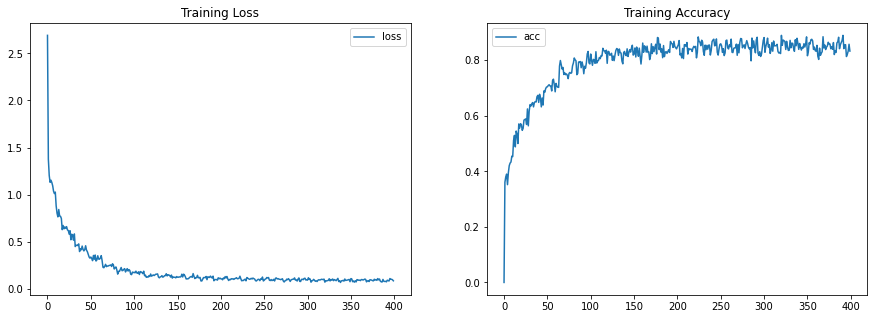

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(losses, label='loss')
ax1.set_title('Training Loss')
ax1.legend()

ax2.plot(accuracies, label='acc')
ax2.set_title('Training Accuracy')
ax2.legend()

plt.show()

### Testing the model
The following cell allows loading the last checkpoint of the previously saved training.

In [19]:
# Loading the latest available checkpoint
checkpoint_dir = './seq2seq'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

To make a prediction, you must provide a sequence of length 1 containing the sos (start-of-sentence) token. Then, it is possible to call the encoder and decoder repeatedly until you receive the eos (end-of-sentence) token or reach the maximum length limit.

In [20]:
def predict(input_text, encoder, input_max_len, tokenizer_inputs, word2idx_outputs, idx2word_outputs):
    if input_text is None:
        input_text = input_data[np.random.choice(len(input_data))]
        print(input_text)
    # Tokenization of the input sequence
    input_seq = tokenizer_inputs.texts_to_sequences([input_text])
    # Padding of the input sequence
    input_seq = pad_sequences(input_seq, maxlen=input_max_len, padding='post')
    print(input_seq)

    # Initialization of encoder states
    en_initial_states = encoder.init_states(1)
    en_outputs = encoder(tf.constant(input_seq), en_initial_states)
    # Creation of input to the decoder, using the <start-of-sentence> token
    de_input = tf.constant([[word2idx_outputs['<sos>']]])
    # Setting the decoder states to the output states from the encoder
    # Set the decoder states to the encoder vector or encoder hidden state
    de_state_h, de_state_c = en_outputs[1:]
    
    out_words = []
    while True:
        # Decoding and retrieval of output probabilities
        de_output, de_state_h, de_state_c = decoder(
            de_input, (de_state_h, de_state_c))
        # Selection of the most probable word
        de_input = tf.argmax(de_output, -1)
        # Insertion of the word into the output sequence
        out_words.append(idx2word_outputs[de_input.numpy()[0][0]])
        # Termination of the loop when the <end-of-sentence> token is encountered
        # or when the maximum expected sequence length is reached
        if out_words[-1] == '<eos>' or len(out_words) >= 20:
            break

    print(' '.join(out_words))

Testing the model using some examples taken from the training dataset

In [23]:
test_sequences = [input_data[42], input_data[1042], input_data[10042], input_data[4242], input_data[42042]]

for test_sequence in test_sequences:
    print(test_sequence)
    predict(test_sequence, encoder, input_max_len, tokenizer_inputs, word2idx_outputs, idx2word_outputs)
    print('  -----------------  ')

['do it . ', 'tom came . ', 'they re mine . ', 'you re old . ', 'tom was selected . ']
[[16  6  1  0  0  0  0  0  0]]
fallo . <eos>
[[  4 156   1   0   0   0   0   0   0]]
tom e venuto . <eos>
[[ 23  10 225   1   0   0   0   0   0]]
sono mie . <eos>
[[  3  10 152   1   0   0   0   0   0]]
voi siete vecchi . <eos>
[[   4   20 1337    1    0    0    0    0    0]]
tom e stato selezionato . <eos>
